In [1]:
import itertools
import json
import matplotlib.pyplot as plt 

%matplotlib inline
plt.rcParams['font.size'] = 16

import numpy as np

from copy import deepcopy

import qiskit
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib

from qiskit import IBMQ
from qiskit.compiler import assemble
from qiskit.pulse import AcquireChannel, Instruction, DriveChannel, MeasureChannel
from qiskit.result.models import ExperimentResultData
from qiskit.scheduler import measure

from qiskit.ignis.measurement.discriminator.iq_discriminators import \
    LinearIQDiscriminator, QuadraticIQDiscriminator, IQDiscriminationFitter

# utility for discriminator experiment
from utils.discrimination import (dfs, bit_strings, get_cal_names, result_subset, 
                                  get_fidelity, jeffreys_interval, print_fidelity)

# Readout at the Pulse level
Author: Daniel J. Egger

Source code for paper "Qiskit Pulse: Programming Quantum Computers Through the Cloud with Pulses" by Thomas Alexander et al.

## Configuration

In [2]:
# use cache data
use_cache = True

# data directory
data_dir = './data/discriminator_efficiency_experiments'

### IBM Q

To run experiments an IBM system credentials must [first be loaded]([https://github.com/Qiskit/qiskit-terra#executing-your-code-on-a-real-quantum-chip) and then a `hub`, `group` and `project` with access to a Qiskit pulse enabled device must be selected. For more help see the [Qiskit documentation](https://qiskit.org/documentation/).

In [3]:
account_provider = IBMQ.load_account()
hub = 'hub'  # account_provider.credentials.hub
group = 'group'  # account_provider.credentials.group
project = 'project'  # account_provider.credentials.project

In [4]:
# target backend
backend_name = 'ibmq_singapore'

In [5]:
provider = IBMQ.get_provider(hub=hub, group=group, project=project)
backend = provider.get_backend(backend_name)

In [6]:
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()

# Qubit state discrimination

There are many ways to discriminate qubit states:

- **All or nothing discrimination**: two measurements are done, one where all qubits are in the ground state and the second one where all qubits are in the excited state.
- **Full basis**: calibration schedules are executed for each basis state. Therefore, a system with N qubits will require $2^N$ calibration circuits.
- **Neighborhood discrimination**: a full basis calibration on the qubits within a given distance $d$ is run. The total number of measurements is thus $\sum_k 2^{N_{d,k}}$

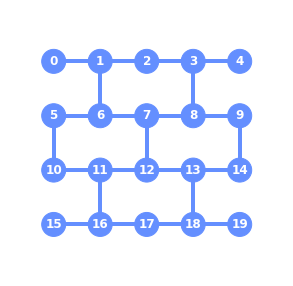

In [7]:
qiskit.visualization.plot_gate_map(backend)

In [8]:
# target qubit pair
qubits = [16, 17]

# buffer time between the last pulse and measurement stimulus (cycle times)
meas_buffer = 2

# number of measurement
shots = 1024

In [9]:
inst_map = defaults.instruction_schedule_map

In [10]:
n_qubits = len(qubits)
schedules = []
schedule_names = set()

for include_xps in itertools.product([True, False], repeat=n_qubits):
    sched_name = 'cal_' + ''.join(['1' if q else '0' for q in include_xps][::-1])  # Little Endian
    
    if sched_name in schedule_names:
        continue
    else:
        schedule_names.add(sched_name)
    
    schedule = pulse.Schedule(name=sched_name)
    
    # Add the Xp gate for selected qubits.
    for idx, q in enumerate(qubits):
        if include_xps[idx]:
            xgate = inst_map.get('x', qubits=q)
            schedule += xgate
            
    schedule += measure(qubits=qubits, backend=backend) << (schedule.duration + meas_buffer)    
    schedules.append(schedule)

cal_11


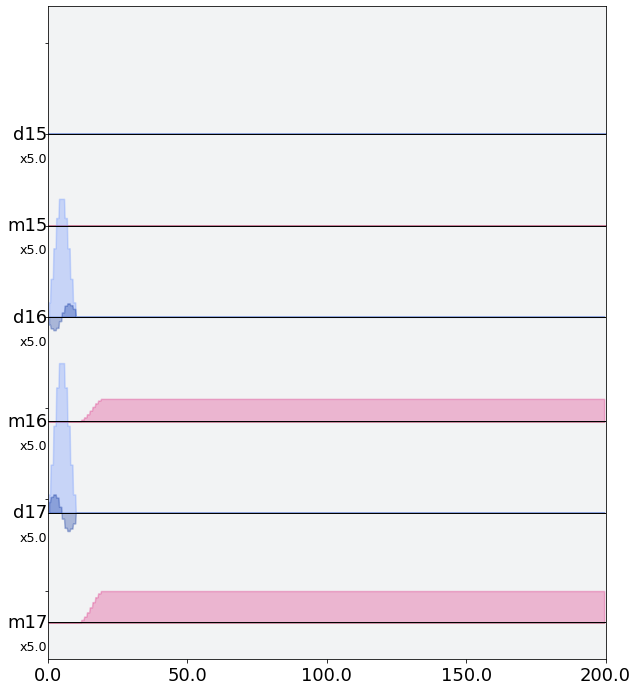

In [11]:
plt_chs = []
for q in [16, 17, 15]:#qubits:
    plt_chs.append(MeasureChannel(q))
    plt_chs.append(DriveChannel(q))

idx = 0
print(schedules[idx].name)
schedules[idx].draw(channels_to_plot=plt_chs, scaling=5.,plot_range=(0, 200))

### Fitting a discriminator

In [12]:
file_name = '20191118_Singapore_qubits_16_17'

if not use_cache:
    job = backend.run(qobj)
    print(job.job_id())
    result = job.result(timeout=3600)
    state = {
        'qobj': qobj.to_dict(),
        'result': result.to_dict(),
        'qubits': qubits
    }
    with open('%s/%s.json' % (data_dir, file_name), 'w') as fp:
        json.dump(state, fp)
else:
    with open('%s/%s.json' % (data_dir, file_name), 'r') as fp:
        state = json.load(fp)

In [13]:
qubits = state['qubits']
result = qiskit.result.Result.from_dict(state['result'])
qobj = qiskit.qobj.PulseQobj.from_dict(state['qobj'])

shots = result.results[0].shots

We use the calibration schedules `cal_00` and `cal_11` to fit two linear discriminant discriminators. One for each qubit. Doing so also implies that we neglect any qubit-qubit correlations in the single shot data.

In [14]:
cal_namesq0 = ['cal_00', 'cal_01']
cal_namesq1 = ['cal_00', 'cal_10']
cal_names_both = ['cal_00', 'cal_01', 'cal_10', 'cal_11']

cal_resultsq0 = result_subset(result, cal_namesq0)
cal_resultsq1 = result_subset(result, cal_namesq1)
cal_results_both = result_subset(result, cal_names_both)

In [15]:
for idx, res in enumerate(cal_results_both.results):
    print('index %i: ' %idx + res.header.name)

index 0: cal_11
index 1: cal_01
index 2: cal_10
index 3: cal_00


The routine below is the **core of the discriminant analysis**. A call to the constructor also fits the discriminator to the provided results.

In [16]:
discriminators = {}

discriminators['Q0'] = LinearIQDiscriminator(cal_resultsq0, [qubits[0]], ['1', '0'])
discriminators['Q1'] = LinearIQDiscriminator(cal_resultsq1, [qubits[1]], ['1', '0'])
discriminators['Q0Both'] = LinearIQDiscriminator(cal_results_both, qubits, ['1', '1', '0', '0'])
discriminators['Q1Both'] = LinearIQDiscriminator(cal_results_both, qubits, ['1', '0', '1', '0'])

We need to modify the y value to be able to calculate the fidelity for both using a discriminator trained on a single qubit.

In [17]:
fq0_single = get_fidelity(discriminators['Q0'], cal_resultsq0, shots, ['1', '0'])
fq0_both = get_fidelity(discriminators['Q0Both'], cal_results_both, shots, ['1', '1', '0', '0'])

fq1_single = get_fidelity(discriminators['Q1'], cal_resultsq1, shots,  ['1', '0'])
fq1_both = get_fidelity(discriminators['Q1Both'], cal_results_both, shots, ['1', '0', '1', '0'])

print_fidelity(fq0_single, 0, '[0]')
print_fidelity(fq0_both, 0, '[0, 1]')
print_fidelity(fq1_single, 1, '[0]')
print_fidelity(fq1_both, 1, '[0, 1]')

Fidelity of Q0 discriminator using qubits [0]: 89.21%, +1.78%, -2.00%
Fidelity of Q0 discriminator using qubits [0, 1]: 89.48%, +1.26%, -1.38%
Fidelity of Q1 discriminator using qubits [0]: 91.06%, +1.42%, -1.65%
Fidelity of Q1 discriminator using qubits [0, 1]: 90.62%, +1.05%, -1.16%


In [18]:
def serialize(data):
    if isinstance(data, dict):
        for key, val in data.items():
            data[key] = serialize(val)
    elif isinstance(data, np.ndarray):
        data = data.tolist()
    return data

In [19]:
# Save data for plotting in numpy format. Avoids issues with qiskit versions
for qubit in ['Q0', 'Q1']:
    x_data = np.array(discriminators[qubit]._xdata)
    y_data = np.array(discriminators[qubit]._ydata)

    max_i = np.max(x_data[:, 0])
    min_i = np.min(x_data[:, 0])
    max_q = np.max(x_data[:, 1])
    min_q = np.min(x_data[:, 1])

    spacing = (max_i - min_i) / 100.0
    xx, yy = np.meshgrid(np.arange(min_i - 10 * spacing, max_i + 10 * spacing, spacing), 
                         np.arange(min_q - 10 * spacing, max_q + 10 * spacing, spacing))

    zz = discriminators[qubit].discriminate(np.c_[xx.ravel(), yy.ravel()])
    zz = np.array(zz).astype(float).reshape(xx.shape)

    y_disc = np.array(discriminators[qubit].discriminate(x_data))
    misclassified = x_data[y_disc != y_data]

    data = {}
    q_idx = 0
    n_qubits = 1
    for _, exp_state in discriminators[qubit].expected_states.items():

        if exp_state not in data:
            data[exp_state] = {'I': [], 'Q': [], 'Imis': [], 'Qmis': []}

        dat = x_data[(y_data == exp_state) & (y_disc == y_data)]*1e-15
        data[exp_state]['I'].extend(dat[:, q_idx])
        data[exp_state]['Q'].extend(dat[:, n_qubits + q_idx])
        dat = x_data[(y_data == exp_state) & (y_disc != y_data)]*1e-15
        data[exp_state]['Imis'].extend(dat[:, q_idx])
        data[exp_state]['Qmis'].extend(dat[:, n_qubits + q_idx])
    
    file_path = '%s/discrimination_plot_data%s.json' % (data_dir, qubit)

    data_to_dump = {
        'xx': xx*1e-15,
        'yy': yy*1e-15,
        'zz': zz,
        'data': data,
        'misclassified': misclassified,
        'y_disc': y_disc,
        'x_data': x_data,
        'y_data': y_data
    }

    with open(file_path, 'w') as fp:
        json.dump(serialize(data_to_dump), fp)

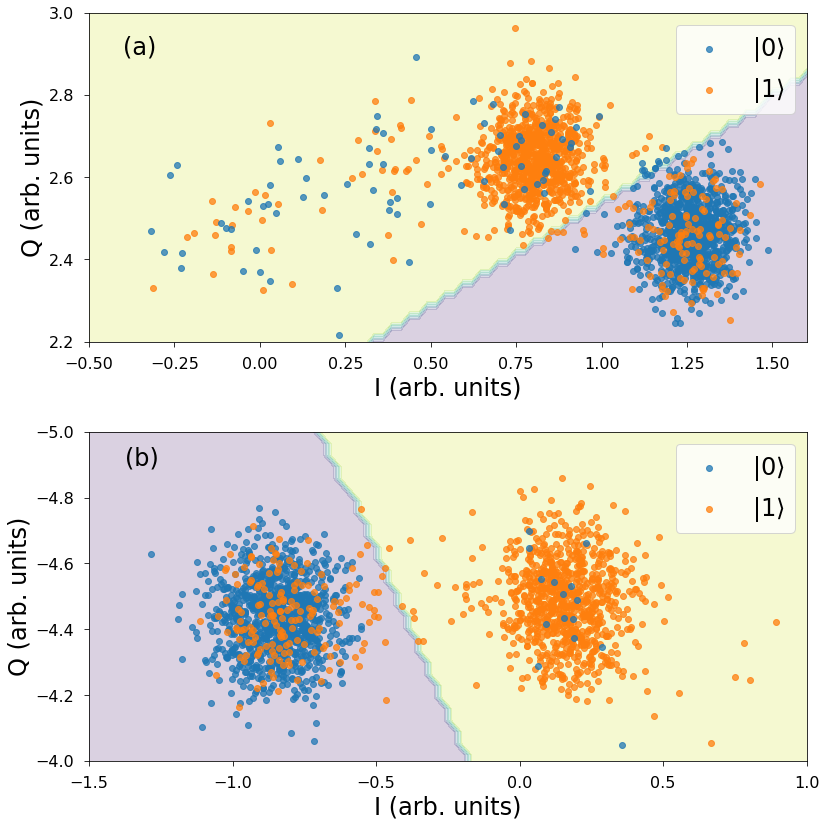

In [20]:
fig, ax = plt.subplots(2,1, figsize=(12,12))

plt.rcParams['font.size'] = 24

for idx, qubit in enumerate(['Q0', 'Q1']):
    file_path = '%s/discrimination_plot_data%s.json' % (data_dir, qubit) 
    with open(file_path, 'r') as fp:
        ld = json.load(fp)
    
    data = ld['data']
    
    ax[idx].contourf(ld['xx'], ld['yy'], ld['zz'], alpha=.2)
    ax[idx].scatter(data['0']['I'], data['0']['Q'], color='C0', label='$|0 \\rangle$', alpha=0.75)
    ax[idx].scatter(data['1']['I'], data['1']['Q'], color='C1', label='$|1 \\rangle$', alpha=0.75)
    ax[idx].scatter(data['0']['Imis'], data['0']['Qmis'], color='C0', alpha=0.75)
    ax[idx].scatter(data['1']['Imis'], data['1']['Qmis'], color='C1', alpha=0.75)
    ax[idx].set_xlabel('I (arb. units)', fontsize=24)
    ax[idx].set_ylabel('Q (arb. units)', fontsize=24)
    ax[idx].tick_params(axis='both', which='major', pad=10, length=5)

ax[0].legend(loc=1)
ax[0].set_ylim([2.2, 3])
ax[0].set_xlim([-0.5, 1.6])
ax[0].text(-0.4, 2.9, '(a)')

ax[1].legend(loc=1)
ax[1].set_ylim([-4.0, -5.0])
ax[1].set_xlim([-1.5, 1.0])
ax[1].text(-1.375, -4.9, '(b)')

fig.tight_layout()

plt.savefig('figs/iq_data.pdf', bbox_inches='tight')
plt.savefig('figs/iq_data.png', bbox_inches='tight', dpi=300)

Text(0.5, 0.98, 'Single-qubit discriminators')

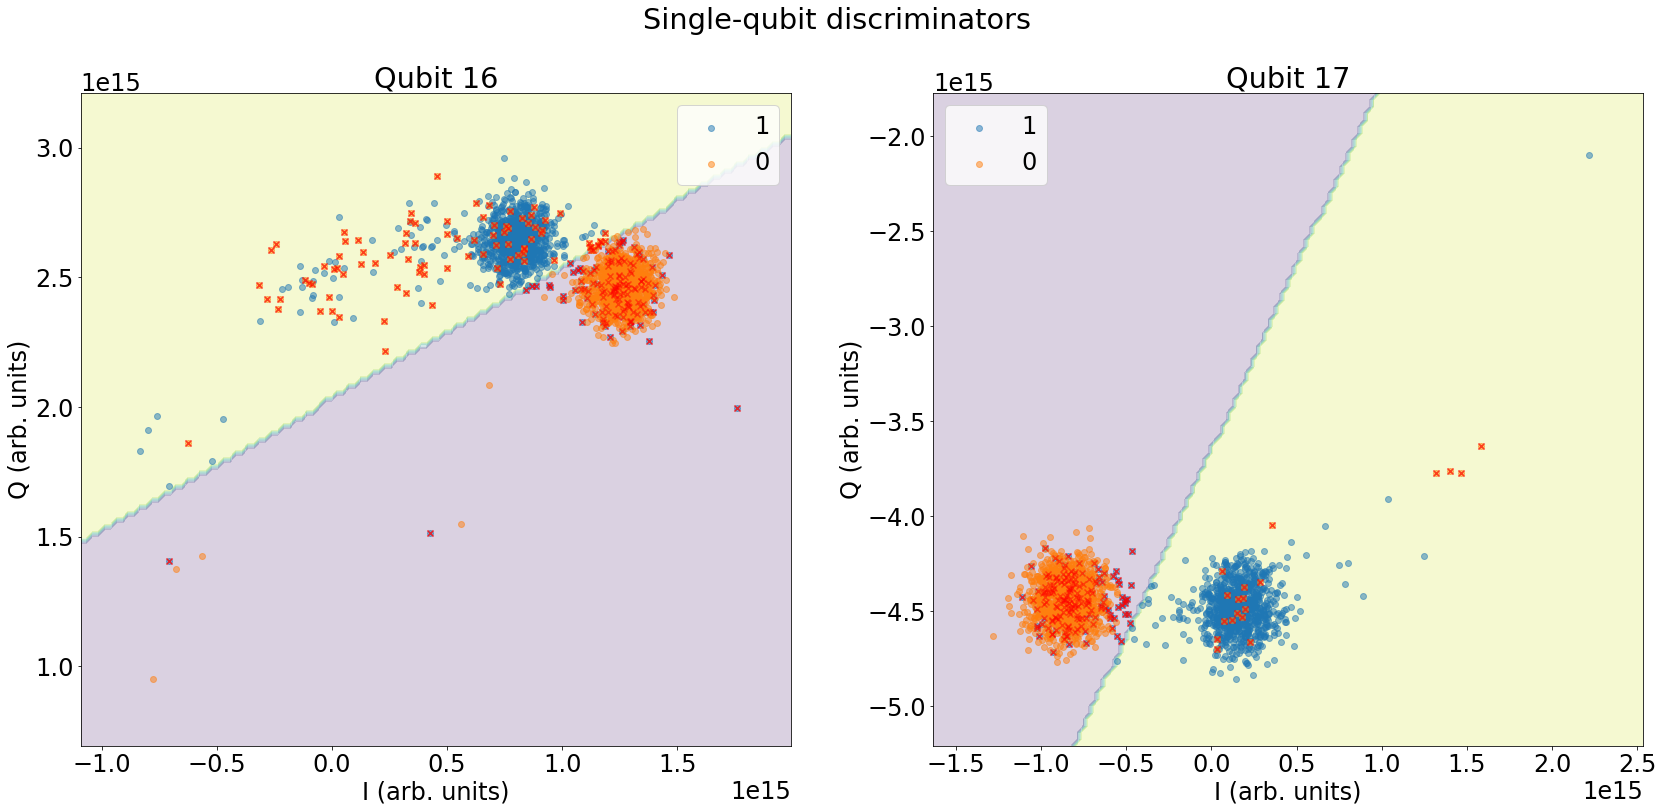

In [21]:
fig, ax1 = plt.subplots(1, 2, figsize=(28, 12))
discriminators['Q0'].plot(ax1[0], flag_misclassified=True, show_boundary=True)
discriminators['Q1'].plot(ax1[1], flag_misclassified=True, show_boundary=True)
plt.suptitle('Single-qubit discriminators')

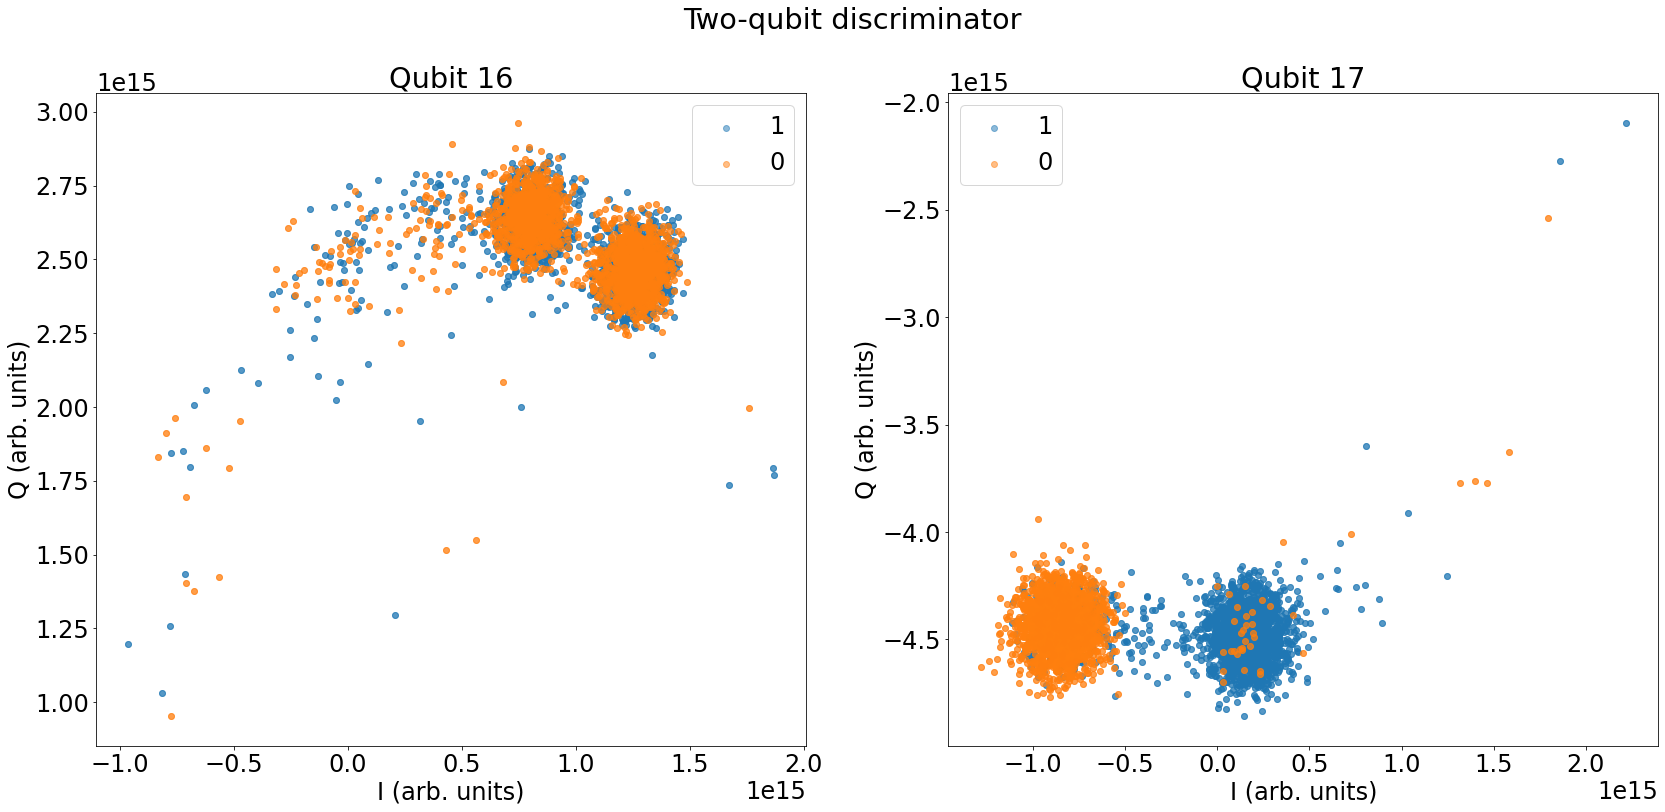

In [22]:
fig, ax2 = plt.subplots(1,2, figsize=(28, 12))
discriminators['Q1Both'].plot(ax2, flag_misclassified=False)
plt.suptitle('Two-qubit discriminator');

In [23]:
cal00 = result_subset(result, 'cal_00')
cal01 = result_subset(result, 'cal_01')
cal10 = result_subset(result, 'cal_10')
cal11 = result_subset(result, 'cal_11')

state00 = np.array(discriminators['Q0Both'].get_xdata(cal00, 0))
state01 = np.array(discriminators['Q0Both'].get_xdata(cal01, 0))
state10 = np.array(discriminators['Q0Both'].get_xdata(cal10, 0))
state11 = np.array(discriminators['Q0Both'].get_xdata(cal11, 0))

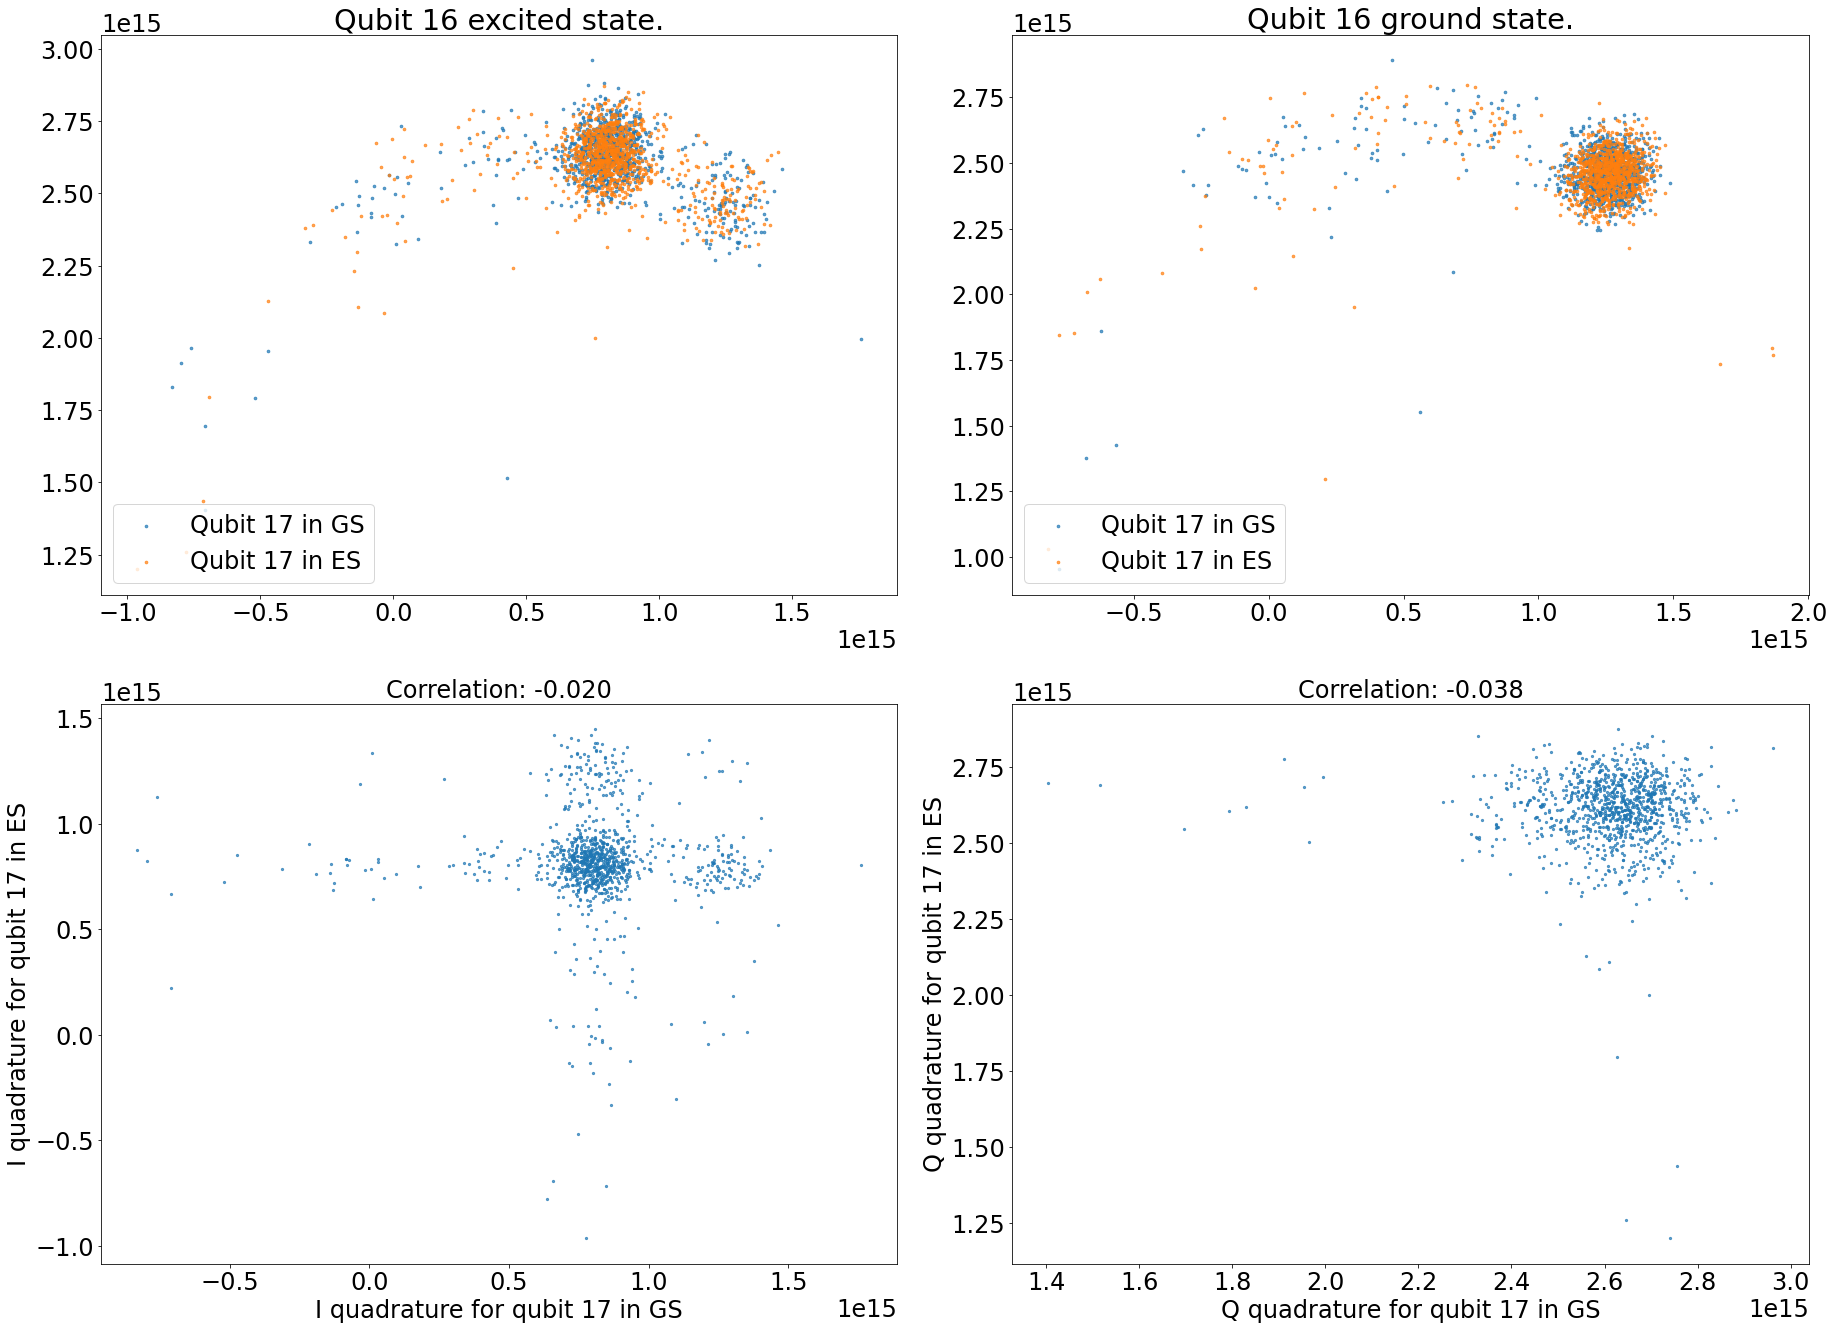

In [24]:
q_idx = 0
ii = q_idx
qq = q_idx + len(qubits)
fig, axs = plt.subplots(2,2,figsize=(26, 19))

axs[0][0].scatter(state01[:, ii], state01[:, qq], alpha=0.7, s=7,
                  label='Qubit {:d} in GS'.format(qubits[(q_idx+1)%2]))
axs[0][0].scatter(state11[:, ii], state11[:, qq], alpha=0.7, s=7,
                  label='Qubit {:d} in ES'.format(qubits[(q_idx+1)%2]))
axs[0][0].set_title('Qubit %i excited state.' % qubits[q_idx])
axs[0][0].legend(loc=3)

axs[0][1].scatter(state00[:, ii], state00[:, qq], alpha=0.7, s=7,
                  label='Qubit {:d} in GS'.format(qubits[(q_idx+1)%2]))
axs[0][1].scatter(state10[:, ii], state10[:, qq], alpha=0.7, s=7,
                  label='Qubit {:d} in ES'.format(qubits[(q_idx+1)%2]))
axs[0][1].set_title('Qubit %i ground state.' % qubits[q_idx])
axs[0][1].legend(loc=3)

for idx in [0, 1]:
    axs[1][idx].set_xlabel('I quadrature')
    axs[1][idx].set_ylabel('Q quadrature')

axs[1][0].scatter(state01[:, ii], state11[:, ii], alpha=0.7, s=5)
axs[1][0].set_xlabel('I quadrature for qubit %i in GS' % qubits[(q_idx+1)%2])
axs[1][0].set_ylabel('I quadrature for qubit %i in ES' % qubits[(q_idx+1)%2])
axs[1][0].set_title('Correlation: {:.3f}'.format(np.corrcoef(state01[:, q_idx], state11[:, q_idx])[0,1]), fontsize=24)

axs[1][1].scatter(state01[:, qq], state11[:, qq], alpha=0.7, s=5)
axs[1][1].set_xlabel('Q quadrature for qubit %i in GS' % qubits[(q_idx+1)%2])
axs[1][1].set_ylabel('Q quadrature for qubit %i in ES' % qubits[(q_idx+1)%2])
axs[1][1].set_title(r'Correlation: {:.3f}'.format(np.corrcoef(state01[:, qq], state11[:, qq])[0,1]), fontsize=24)
plt.tight_layout()

In [25]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright